## Load data and import functions

In [101]:
from eddies import load_netcdf4,eddy_detection,dataframe_eddies,plot_eddies,julianh2gregorian
import os
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from math import cos, pi
import numpy as np
import xarray as xr
import datetime

#name of the netCDF data file
filepath = 'C:/Master/data/cmems_data/global_10km/phys_noland_001.nc'

# load data
(ds,t,lon,lat,depth,uvel,vvel,sst,ssl) =  load_netcdf4(filepath)

# Confidence level, usually 90%
R2_criterion = 0.9

# OW value at which to begin the evaluation of R2, default was -1, want to use -8 to be absolutely sure
OW_start = -6.0

# Number of local minima to evaluate using R2 method.
# Set low (like 20) to see a few R2 eddies quickly.
# Set high (like 1e5) to find all eddies in domain.
max_evaluation_points = 2000 #set to 2000 to capture avery minima, there should be around 1800

# Minimum number of cells required to be identified as an eddie.
min_eddie_cells = 2 # set to 3 to be coherent with the use of the R2 method, 3 points seems like a reasonable minimun for a correlation 

# z-level to plot.  Usually set to 0 for the surface.
k_plot = 0

In [5]:
t

NameError: name 't' is not defined

## Run OW-R2 algorithm

In [2]:
%%capture
day = 0
lon,lat,u,v,vorticity,OW,OW_eddies,eddie_census,nEddies,circulation_mask = eddy_detection(
    lon,lat,depth,uvel,vvel,day,R2_criterion,OW_start,max_evaluation_points,min_eddie_cells)

## Prepare datasets and lists

In [3]:
eddyCtrIdx = []
for i in range(0,nEddies):
    lonIdx = np.argmax(lon>eddie_census[2,i])-1
    latIdx = np.argmax(lat>eddie_census[3,i])-1
    eddyCtrIdx.append( (lonIdx, latIdx) )

sst = sst[0,:,:].T
ssl = ssl[0,:,:].T
uvel = uvel[0,:,:].T
vvel = vvel[0,:,:].T

images = [
    {
        'longitude': [],
        'latitude': [],
        'sst': [],
        'ssl': [],
        'uvel': [],
        'vvel': [],
        'phase': [],
        'class': -1
     }
     for i in range(nEddies) 
]

## Plot the temperature and water level map with boxes showing eddies

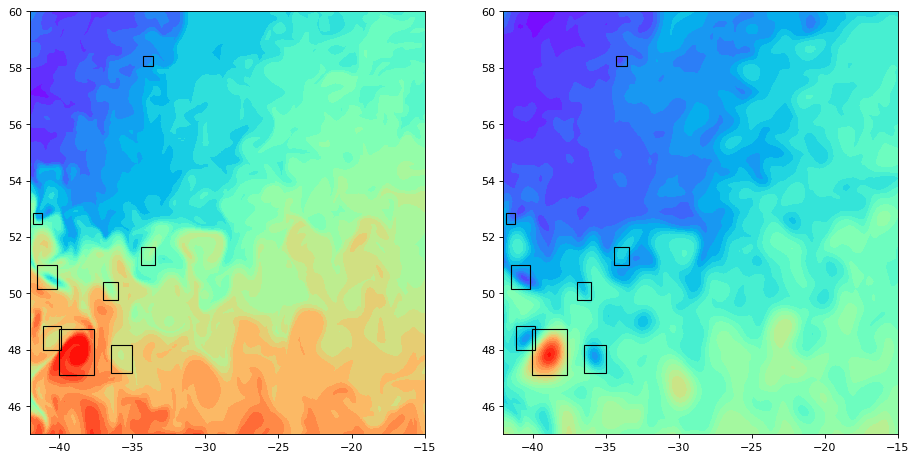

In [4]:


fig, axs = plt.subplots(1,2, figsize=(14,7), dpi= 80, facecolor='w', edgecolor='w', )

sst_im = axs[0].contourf(lon, lat, sst.T, 25, cmap='rainbow',)
ssl_im = axs[1].contourf(lon, lat, ssl.T, 25, cmap='rainbow',)

for ax in axs:
    for i in range(nEddies):

        radius = eddie_census[5][i] * 1000 / 2 # eddie_census is diameter in km
        ctrLat = lat[eddyCtrIdx[i][1]]     # Centre latitude, to get correct longitude depending on what latitude we're on
        height = radius * 2.0 / 110.54e3 # 1 deg = 110.54 km 
        width = radius * 2.0 / (111.320e3 * cos(ctrLat*2*pi/360)) # 1 deg = 111.320*cos(latitude) km, using centre latitude as ref

        #print(f"width: {width}, height: {height}")
        bottomleft = (eddie_census[2][i]-width/2, eddie_census[3][i]-height/2)
        #print(f"Bottom left coordinates: {bottomleft}\n\n")

        rect = Rectangle(bottomleft, width, height, linewidth=1, edgecolor='k', facecolor='none')
        ax.add_patch(rect)

## Add all rectangular patches to an array of eddies

We also include all data which might be interesting to test as training data for a deep learner. First dimension is the eddies (0:nEddies), with a dictionary of the following variables:
* **longitude**
* **latitude**
* **sst**: Sea Surface Temperature
* **ssl**: Sea Surface Level
* **uvel**: Eastward ocean current velocity
* **vvel**: Northward ocean current velocity
* **phase**: Phase angle of the ocean current, i.e. its direction.

In [5]:
for i in range(nEddies): # nEddies
    centreCoord = (eddyCtrIdx[i][0], eddyCtrIdx[i][1])

    radius = eddie_census[5][i] * 1000 *2 / 2 # eddie_census is diameter in km
    # Change to square, since we are using the radius anyways

    height = 1.8 * abs(radius / 110.54e3) # 1 deg = 110.54 km, 1.2 to be sure the image covers the eddy
    width = 1.8 * abs(radius / (111.320e3 * cos(centreCoord[1]))) # 1 deg = 111.320*cos(latitude) km, using centre latitude as ref
    
    lon_bnds = [eddie_census[2][i]-width/2.0, eddie_census[2][i]+width/2.0] 
    lat_bnds = [eddie_census[3][i]-height/2.0, eddie_census[3][i]+height/2.0] 
    
    # Indeces of current eddy image
    lonIdxs = np.where((lon > lon_bnds[0]) & (lon < lon_bnds[1]))[0]
    latIdxs = np.where((lat > lat_bnds[0]) & (lat < lat_bnds[1]))[0]
    
    sst_eddy   =   np.zeros((lonIdxs.size,latIdxs.size))
    ssl_eddy   =   np.zeros((lonIdxs.size,latIdxs.size))
    uvel_eddy  =   np.zeros((lonIdxs.size,latIdxs.size))
    vvel_eddy  =   np.zeros((lonIdxs.size,latIdxs.size))
    phase_eddy =   np.zeros((lonIdxs.size,latIdxs.size))

    # Positive rotation (counter-clockwise) is a cyclone in the northern hemisphere because of the coriolis effect
    if (eddie_census[1][i] > 0.0): images[i]['class'] = 1 # 1 is a cyclone, 0 is nothing and -1 is anti-cyclone (negative rotation)
    else: images[i]['class'] = -1
    
    for j, lo in enumerate(lonIdxs):
        for k, la in enumerate(latIdxs):
            #idx = j*latIdxs.size + k
            sst_eddy[j,k] = sst[lo,la]
            ssl_eddy[j,k] = ssl[lo,la]
            uvel_eddy[j,k] = uvel[lo,la]
            vvel_eddy[j,k] = vvel[lo,la]
            # Calculate the phase angle (direction) of the current
            with np.errstate(all='ignore'): # Disable zero div warning
                phase_eddy[j,k] = xr.ufuncs.rad2deg( xr.ufuncs.arctan2(vvel[lo,la], uvel[lo,la]) ) + 180
    
    images[i]['longitude'] = lon[lonIdxs]
    images[i]['latitude'] = lat[latIdxs]
    images[i]['sst'] = sst_eddy
    images[i]['ssl'] = ssl_eddy
    images[i]['uvel'] = uvel_eddy
    images[i]['vvel'] = vvel_eddy
    images[i]['phase'] = phase_eddy

## Create images of the rectangular patches

In [25]:
def check_cyclone(flag):
    # positive 1 denotes positive rotation, which is a cyclone in the norther hemisphere
    if flag==1:   return "cyclone"
    elif flag==-1:return "anticyclone"
    else:         return "nothing"

C:\Users\evenwa\AppData\Local\Continuum\anaconda3\envs\oceanography\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  from ipykernel import kernelapp as app


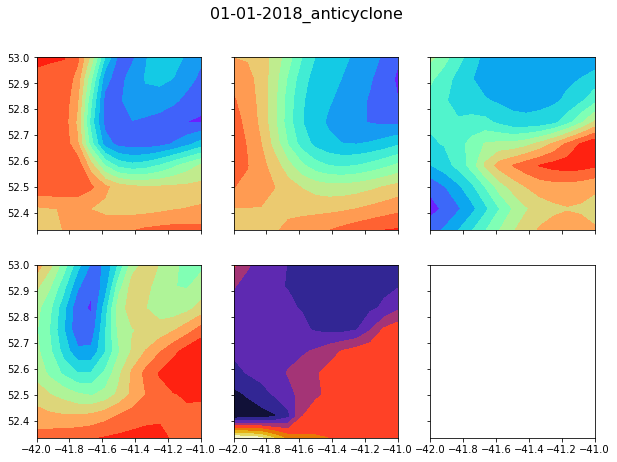

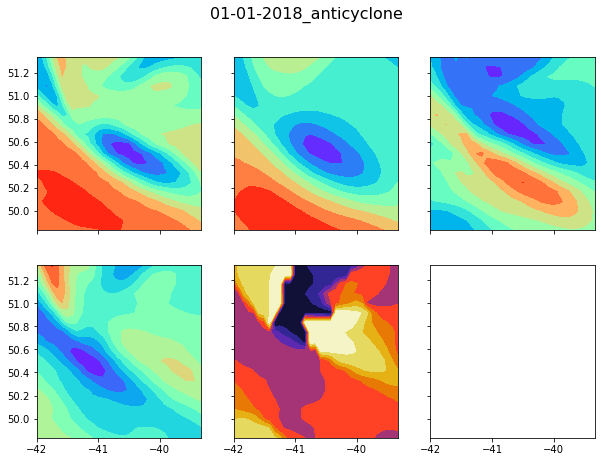

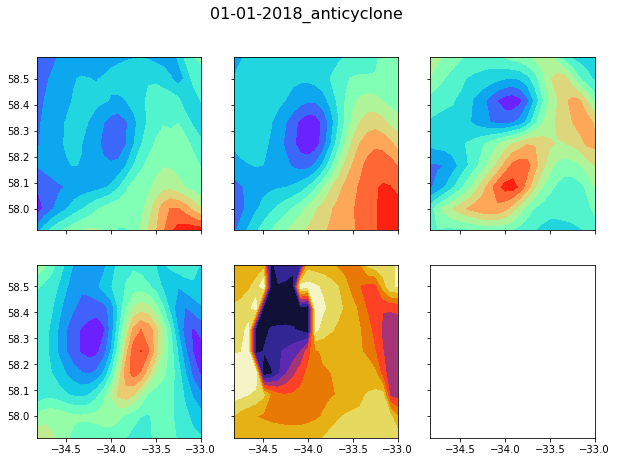

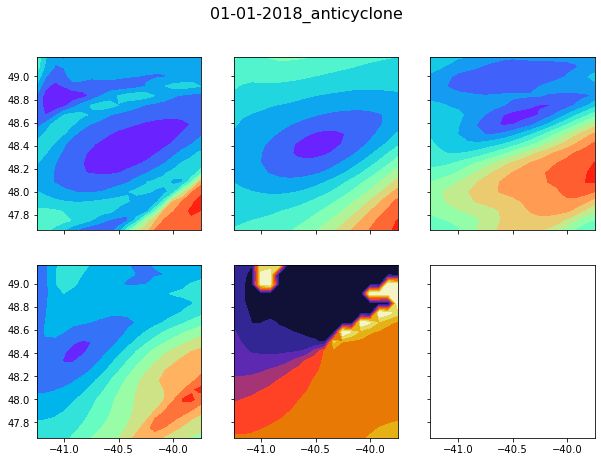

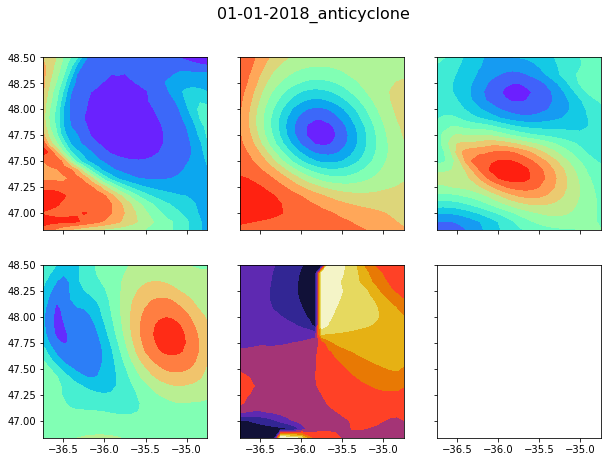

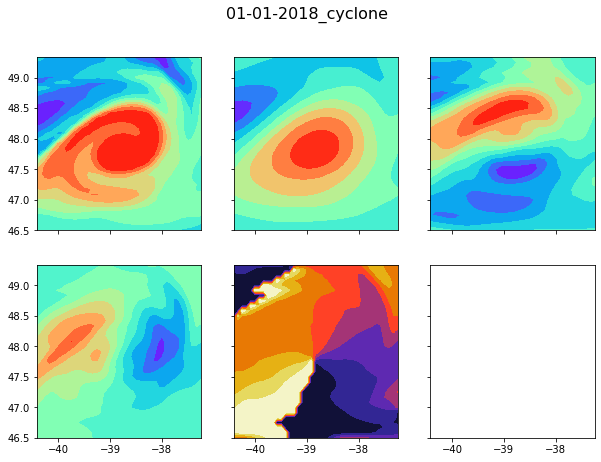

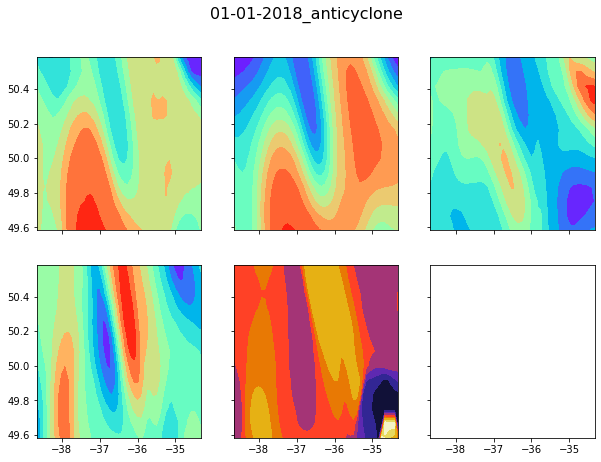

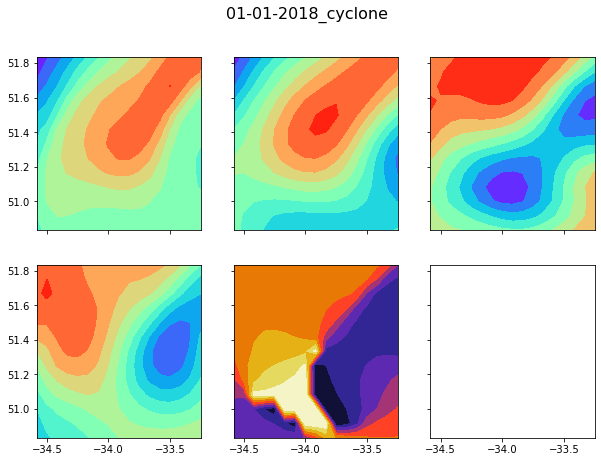

In [100]:
import os
dateStr = "{:%d-%m-%Y}".format(datetime.date(1950, 1, 1) + datetime.timedelta(hours=float(t[0])) )
dirPath = 'C:/Master/TTK-4900-Master/images/'+dateStr+'/'
if not os.path.exists(dirPath):
    os.makedirs(dirPath)

for imId in range(nEddies):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)
    lo = images[imId]['longitude']
    la = images[imId]['latitude']
    axs[0,0].contourf(lo, la, images[imId]['sst'].T, 10, cmap='rainbow')
    axs[0,1].contourf(lo, la, images[imId]['ssl'].T, 10, cmap='rainbow')
    axs[0,2].contourf(lo, la, images[imId]['uvel'].T, 10, cmap='rainbow')
    axs[1,0].contourf(lo, la, images[imId]['vvel'].T, 10, cmap='rainbow')
    axs[1,1].contourf(lo, la, images[imId]['phase'].T, 10, add_colorbar=True, cmap='CMRmap')
    title = dateStr + "_" + check_cyclone(images[imId]['class'])
    fig.suptitle(title, fontsize=16)
    imPath = dirPath + title + f"_{imId}.png"     
    plt.savefig(imPath, bbox_inches='tight')